# Ensembles

_This notebook is adapted from ch. 7: Ensemble learning and Random Forests, from Hands-on Machine Learning by A. Geron._


# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [ ]:

import sklearn
import numpy as np
import os
from math import log, exp

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Voting classifiers

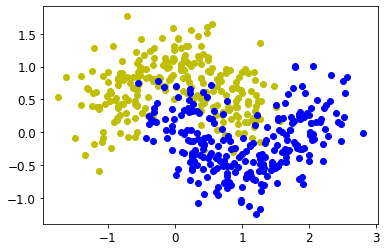

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

# create a classification dataset
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bo") 

In [4]:
from sklearn.tree import DecisionTreeClassifier  # note: changed example from random forest to decision tree here 
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# set up different models for the voting classifier.
log_clf = LogisticRegression(random_state=42)
dt_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('dt', dt_clf), ('svc', svm_clf)],
    voting='hard')

In [5]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('dt',
                              DecisionTreeClassifier(max_depth=2,
                                                     random_state=42)),
                             ('svc', SVC(random_state=42))])

In [6]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, dt_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
DecisionTreeClassifier 0.896
SVC 0.896
VotingClassifier 0.904


# Bagging ensembles

In [7]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# make a bagging ensemble of decision tree
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [8]:
from sklearn.metrics import accuracy_score

# accuracy of the bagging ensemble of decisison trees
print(accuracy_score(y_test, y_pred))

0.904


In [9]:
# compared to that of an individual tree
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


### Decision boundary of a bagging ensemble of decision trees

The bagging ensemble has reduced variance compared to single trees, and so has better generalization. It has a smoother decision boundary. Bias is comparable to the single model. 

In [10]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Saving figure decision_tree_without_and_with_bagging_plot


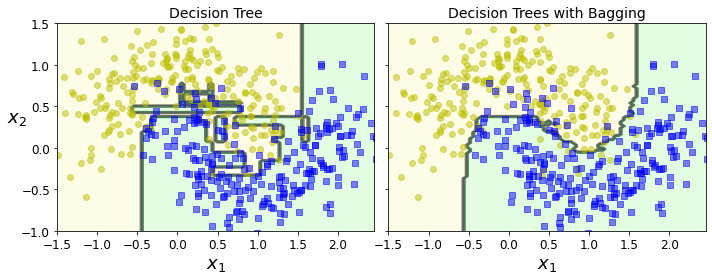

In [11]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

## Out-of-Bag evaluation

The performance of each classifier in the ensemble is evaluated on its out-of-bag samples. 

In [12]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [13]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

# Random Forests

In [16]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42, max_depth=20)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

Text(0.5, 1.0, 'Random Forest')

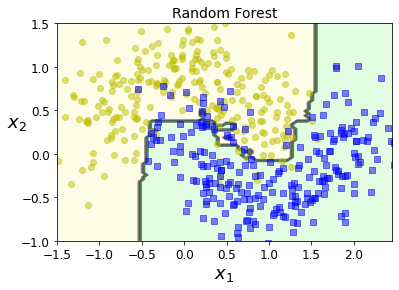

In [17]:
plot_decision_boundary(rnd_clf, X, y)
plt.title("Random Forest", fontsize=14)

# AdaBoost

### Weights

The weighted error of a model $m$ in the boosting ensemble is measured by $\epsilon_m$ (in the range $[0,1]$).

The weighting coefficient for $m$ is $\alpha_m = \mathrm{ln} \dfrac{1 - \epsilon_m}{\epsilon_m}$.

The plots below show $\alpha_m$ as a function of $\epsilon_m$, and the resulting training instance weight multipliers.

In [24]:
def alpha(e):
    return log((1-e)/e)

def w_mult(a):
    return exp(a)

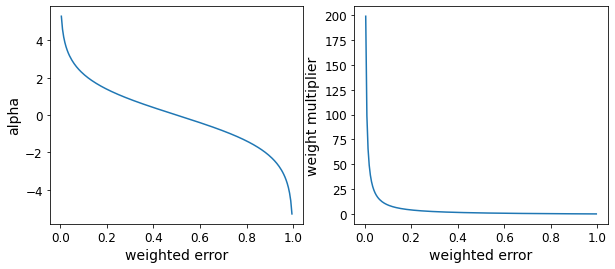

In [25]:
es = np.arange(0.005,1,0.005)
a_s = [alpha(e) for e in es]
w = [w_mult(a) for a in a_s] 

fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
plt.sca(axes[0])
plt.plot(es,a_s)
plt.xlabel('weighted error')
plt.ylabel('alpha')
plt.sca(axes[1])
plt.plot(es,w)
plt.xlabel('weighted error')
plt.ylabel('weight multiplier')

plt.show()

In [26]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

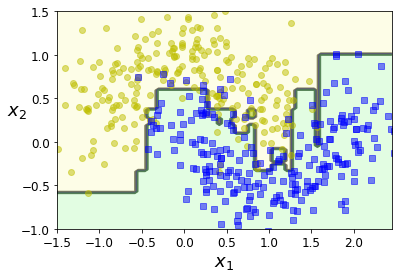

In [27]:
plot_decision_boundary(ada_clf, X, y)

# Gradient Boosting

The code below shows how gradient boosting works, by sequentially fitting 3 regression trees. The first tree is fit to the training data. The 2nd is fit to the residuals from the first. The 3rd is fit to the residuals of the 2nd. 

The final prediction is the sum of predictions from the three regression trees

In [28]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [29]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [30]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [31]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [32]:
X_new = np.array([[0.8]])

In [33]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [34]:
y_pred

array([0.75026781])

In [35]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Saving figure gradient_boosting_plot


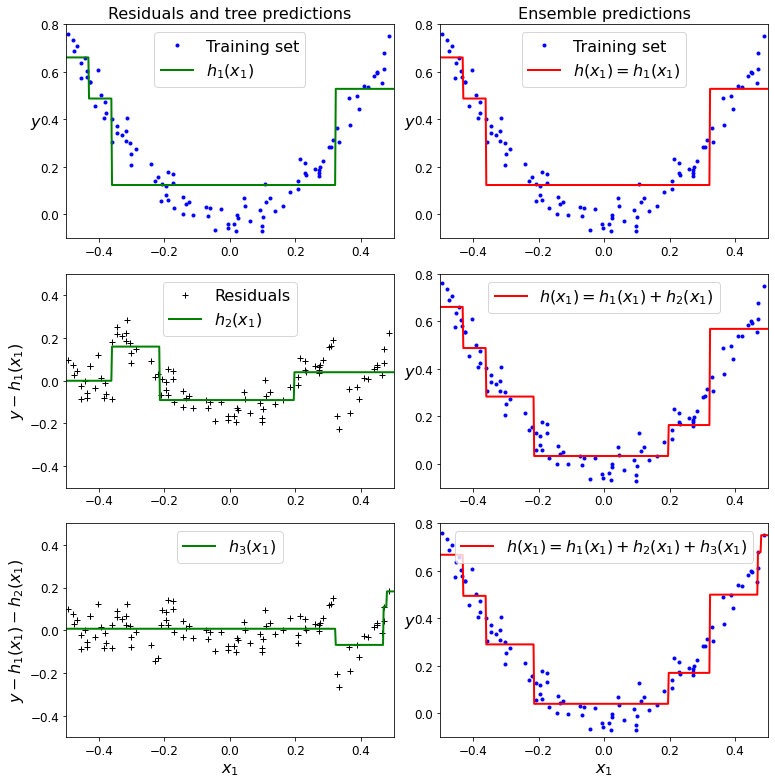

In [36]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

### GradientBoostingRegressor

The code below trains two GradientBoostingRegressors, with different learning rate and number of trees.

In [37]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [38]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

Saving figure gbrt_learning_rate_plot


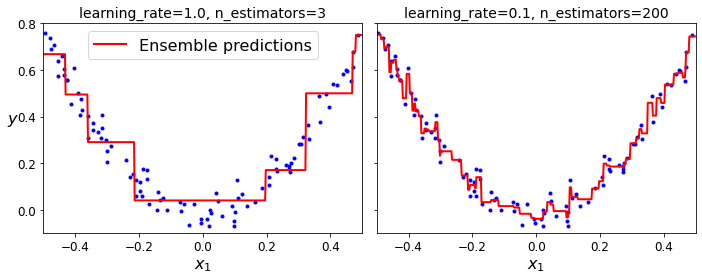

In [39]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()

# Seasonality

Let's try to do a regression on a dataset that has a strong seasonal component with a random forest

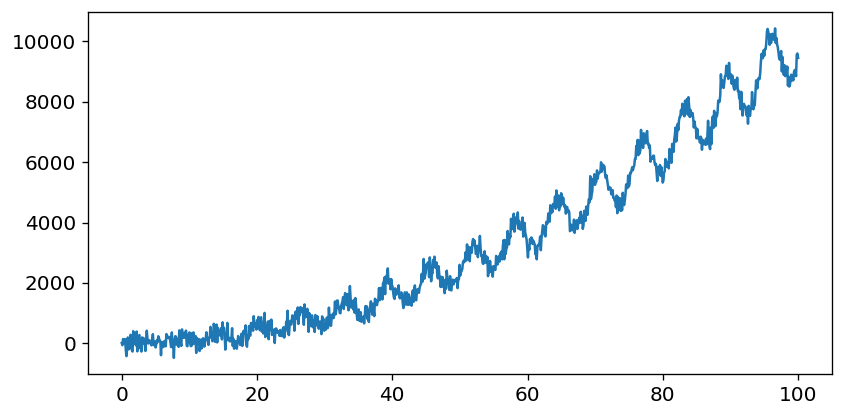

In [328]:
plt.figure(figsize=(8,4))
X = np.linspace(0, 100, 1000).reshape(-1,1)
noise = np.random.normal(0, 200, X.shape[0]).reshape(-1,1) 
y = 10*X*np.sin(X) + X**2 + noise
plt.plot(X,y)

In [329]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(max_depth=7, criterion='squared_error') 
model.fit(X, y)  

/var/folders/4x/h4093mg57t37566vrdrhg7400000gn/T/ipykernel_22617/1304326084.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X, y)


RandomForestRegressor(max_depth=7)

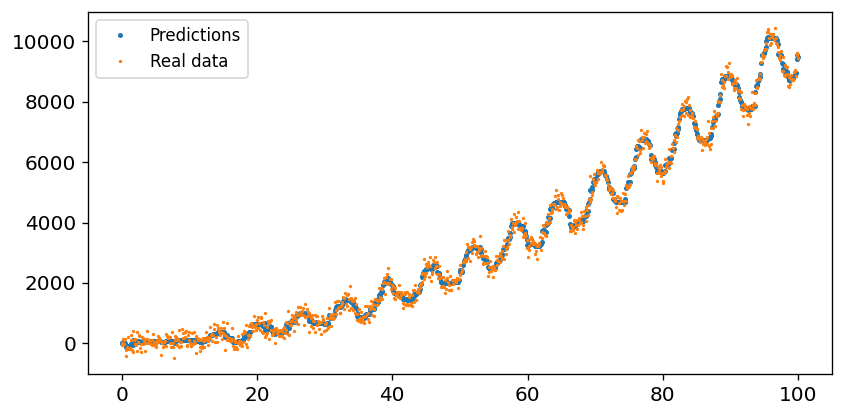

In [330]:
predictions = model.predict(X)
plt.figure(figsize=(8,4))
plt.plot(X, predictions, 'o', markersize=2, label='Predictions')
plt.plot(X, y, 'o', markersize=1, label='Real data')
plt.legend()

### Interpolation

In [331]:
input_train, input_validation, truth_train, truth_validation = train_test_split(X, y, test_size=0.5)
model = RandomForestRegressor(max_depth=7, criterion='squared_error') 
model.fit(input_train, truth_train)  

/var/folders/4x/h4093mg57t37566vrdrhg7400000gn/T/ipykernel_22617/3278744876.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(input_train, truth_train)


RandomForestRegressor(max_depth=7)

We evaluate the model on the training set to sanity check that the model is actually learning

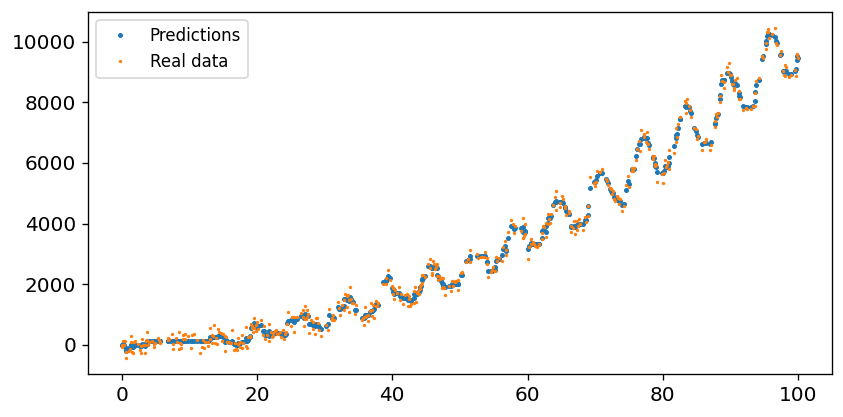

In [332]:
predictions = model.predict(input_train)
plt.figure(figsize=(8,4))
plt.plot(input_train, predictions, 'o', markersize=2, label='Predictions')
plt.plot(input_train, truth_train, 'o', markersize=1, label='Real data')
plt.legend()

And now we evaluate it on the validation set

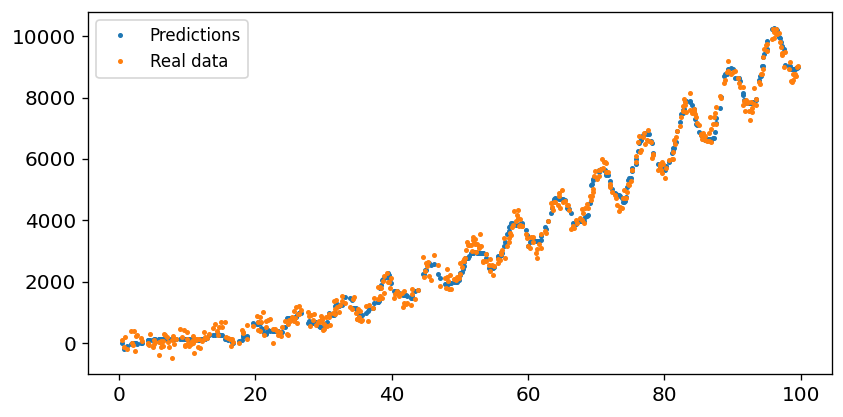

In [333]:
predictions = model.predict(input_validation)
plt.figure(figsize=(8,4))
plt.plot(input_validation, predictions, 'o', markersize=2, label='Predictions')
plt.plot(input_validation, truth_validation, 'o', markersize=2, label='Real data')
plt.legend()

### Extrapolation

Now that we saw that we can interporlate, let's check if we can extrapolate:

In [336]:
X = np.linspace(0, 100, 10000).reshape(-1,1)
noise = np.random.normal(0, 200, X.shape[0]).reshape(-1,1) 
y = 10*X*np.sin(X) + X**2 + noise

input_train, truth_train = X[:8000,:], y[:8000] 
input_validation, truth_validation = X[8000:,:], y[8000:] 
model = RandomForestRegressor(max_depth=7, criterion='squared_error') 
model.fit(input_train, truth_train)  

/var/folders/4x/h4093mg57t37566vrdrhg7400000gn/T/ipykernel_22617/1653479842.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(input_train, truth_train)


RandomForestRegressor(max_depth=7)

Let's evaluate the model:

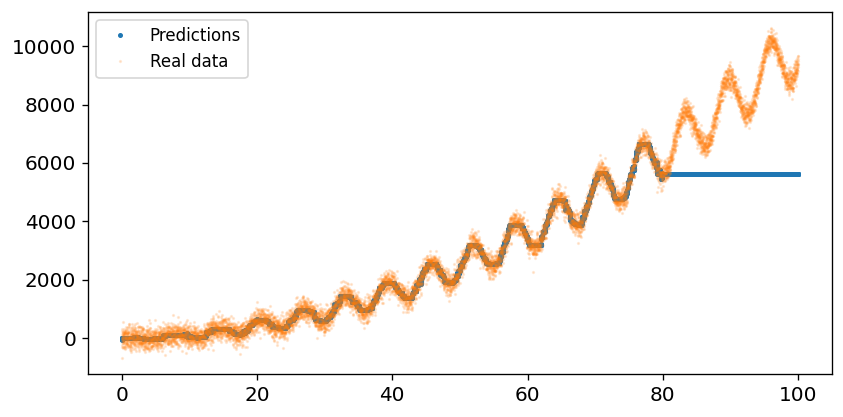

In [341]:
predictions = model.predict(X)
plt.figure(figsize=(8,4))
plt.plot(X, predictions, 'o', markersize=2, label='Predictions')
plt.plot(X, y, 'o', markersize=1, label='Real data', alpha=0.15)
plt.legend()

Our model doesn't extrapolate :(

/var/folders/4x/h4093mg57t37566vrdrhg7400000gn/T/ipykernel_22617/2305624427.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(input_train, truth_train)


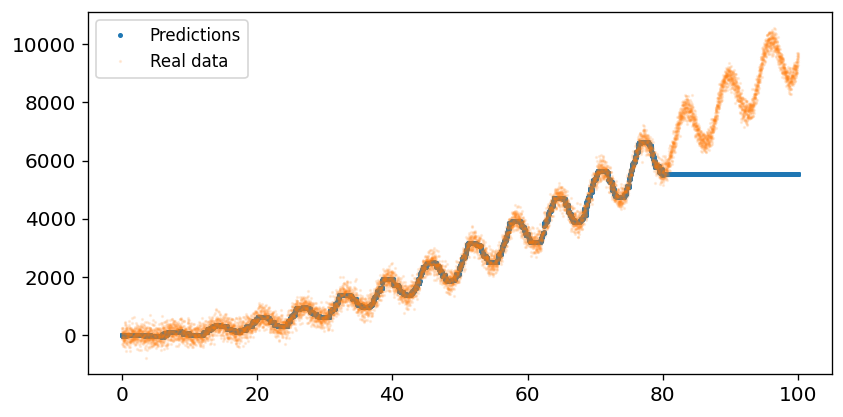

In [344]:
X = np.linspace(0, 100, 10000).reshape(-1,1)
noise = np.random.normal(0, 200, X.shape[0]).reshape(-1,1) 
y = 10*X*np.sin(X) + X**2 + noise

n = 8000
input_train, truth_train = X[:n,:], y[:n] 
input_validation, truth_validation = X[n:,:], y[n:] 

model = RandomForestRegressor(max_depth=7, n_estimators=100)
model.fit(input_train, truth_train)  
predictions = model.predict(X)

plt.figure(figsize=(8,4))
plt.plot(X, predictions, 'o', markersize=2, label='Predictions')
plt.plot(X, y, 'o', markersize=1, label='Real data', alpha=0.12)
plt.legend()

#### Specialised libaries for time-series forecasting 

In [347]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
import pandas as pd

forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(max_depth=10, n_estimators=100),
                lags = 800
                )

X = np.linspace(0, 100, 2000)
noise = np.random.normal(0, 200, X.shape[0])
y = 10*X*np.sin(X) + X**2 + noise

n = 1600
input_train, truth_train = X[:n], y[:n] 
input_validation, truth_validation = X[n:], y[n:] 
training_data = pd.Series(truth_train)
validation_data = pd.Series(truth_validation)


forecaster.fit(training_data)
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(max_depth=10) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 22

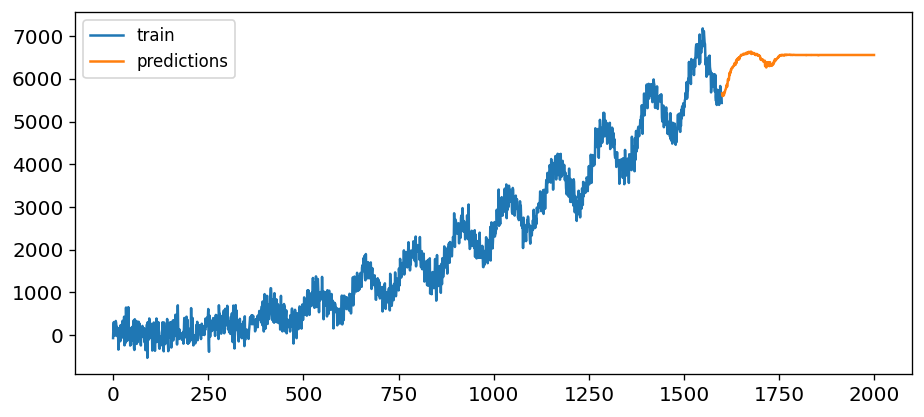

In [350]:
steps = 400
predictions = forecaster.predict(steps=steps)
# predictions
fig, ax = plt.subplots(figsize=(9, 4))
training_data.plot(ax=ax, label='train')
predictions.plot(ax=ax, label='predictions')
ax.legend()

##### Extrapolation is hard 😑